In [1]:
import pandas as pd
import pyodbc

# Connexion to SQL Server
conn = pyodbc.connect(
    "Driver={SQL Server};"
    "Server=DESKTOP-UA5JP12\\SQLEXPRESS;"
    "Database=CreditRiskDW;"
    "Trusted_Connection=yes;"
)

df = pd.read_sql("SELECT * FROM gold.loans_final", conn)
print(df.head())

C:\Users\hp\AppData\Local\Temp\ipykernel_20612\3768080904.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM gold.loans_final", conn)


   loan_amount  term  interest_rate  installment grade sub_grade  \
0      20000.0  36.0          10.41       649.21     B        B3   
1       9000.0  36.0          11.98       298.85     B        B5   
2      10000.0  36.0          12.62       335.12     C        C1   
3       4000.0  36.0           7.97       125.30     A        A5   
4       4800.0  36.0          10.91       156.95     B        B4   

   annual_income  debt_to_income  verified_income homeownership  ...  \
0        50000.0           19.76         VERIFIED      MORTGAGE  ...   
1        55000.0            3.21  SOURCE VERIFIED      MORTGAGE  ...   
2        57500.0           25.30         VERIFIED          RENT  ...   
3        23000.0           23.12  SOURCE VERIFIED           OWN  ...   
4        54000.0           12.98     NOT VERIFIED           OWN  ...   

  num_historical_failed_to_pay total_credit_limit total_credit_utilized  \
0                            1            48207.0               29334.0   
1       

## Dataset Scope Definition

In [2]:
# Keep only relevant columns for risk analysis
risk_cols = [
    'loan_amount','term','interest_rate','installment',
    'grade','sub_grade','annual_income','debt_to_income',
    'verified_income','homeownership','state',
    'application_type','loan_purpose',
    'delinq_2y','num_historical_failed_to_pay',
    'total_credit_limit','total_credit_utilized',
    'loan_status_raw','loan_status_group','loan_outcome',
    'default_flag','balance','paid_total'
]

df = df[risk_cols].copy()

## Let's do some data cleaning first 

In [3]:
# Keep only valid grades
valid_grades = ['A','B','C','D','E','F','G']
df = df[df['grade'].isin(valid_grades)]

In [4]:
df = df[df['term'].isin([36, 60])]

In [5]:
df = df[df["loan_purpose"].apply(lambda x : isinstance(x, str))]

## Feature Engineering - Core Risk Variables

### Credit Utilization Ratio

In [6]:
df["credit_utilization_ratio"] = ( 
    df["total_credit_utilized"] / df["total_credit_limit"] 
)

### Installment Burden (Affordability)

In [7]:
df['installment_to_income'] = (
    df['installment'] * 12 / df['annual_income']
)

## Multi-State Loan Performance Variable

### Define Risk State (Target Variable)

#### Modeling Choice
Rather than collapsing loan performance into a binary default/non-default variable,
we explicitly model intermediate delinquency states to better capture early risk signals
and portfolio dynamics.
HEALTHY < DELINQUENT_EARLY < DELINQUENT_LATE < DEFAULT

In [8]:
def risk_state(row):
    if row['default_flag'] == 1:
        return 'DEFAULT'
    elif row['loan_status_group'] == 'DELINQUENT_LATE':
        return 'DELINQUENT_LATE'
    elif row['loan_status_group'] == 'DELINQUENT_EARLY':
        return 'DELINQUENT_EARLY'
    else:
        return 'HEALTHY'

df['risk_state'] = df.apply(risk_state, axis=1)

### Risk State Distribution Check

In [9]:
df['risk_state'].value_counts(normalize=True)

risk_state
HEALTHY             0.982076
DELINQUENT_EARLY    0.010573
DELINQUENT_LATE     0.006646
DEFAULT             0.000705
Name: proportion, dtype: float64

## Outlier Detection

### Numerical Variables Summary

In [10]:
num_cols = [
    'loan_amount','interest_rate','installment',
    'annual_income','debt_to_income',
    'credit_utilization_ratio','installment_to_income'
]
df[num_cols].describe(percentiles=[.01,.05,.95,.99])

,loan_amount,interest_rate,installment,annual_income,debt_to_income,credit_utilization_ratio,installment_to_income
count,9931.000000,9931.000000,9931.000000,9.931000e+03,9907.000000,9929.000000,9931.000000
mean,16330.299064,12.430312,475.353634,7.885961e+04,19.315266,0.403344,inf
std,10294.025025,4.998112,294.604288,6.450478e+04,15.038270,0.269449,NaN
min,1000.000000,5.310000,30.750000,0.000000e+00,0.000000,0.000000,0.000500
1%,1500.000000,5.310000,53.152000,1.314720e+04,0.840000,0.011439,0.010072
5%,3200.000000,6.070000,107.670000,2.500000e+04,3.753000,0.052315,0.020107
50%,14400.000000,11.980000,396.270000,6.500000e+04,17.560000,0.360772,0.072827
95%,36000.000000,21.450000,1096.290000,1.700000e+05,37.274000,0.864627,0.210935
99%,40000.000000,26.770000,1280.010000,3.000000e+05,58.896600,1.050895,0.388631
max,40000.000000,30.940000,1566.590000,2.300000e+06,469.090000,1.835280,inf


### Visual Outlier Scan

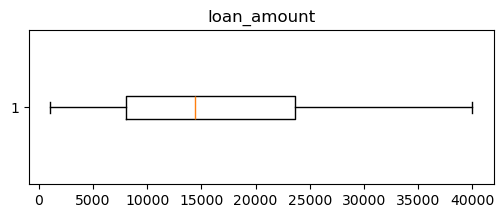

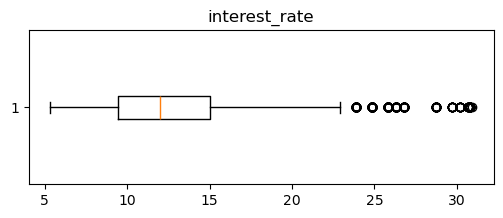

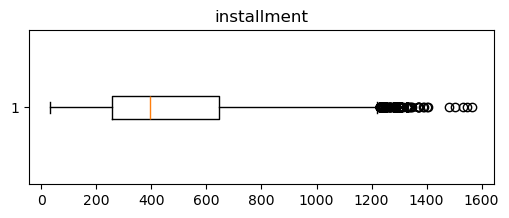

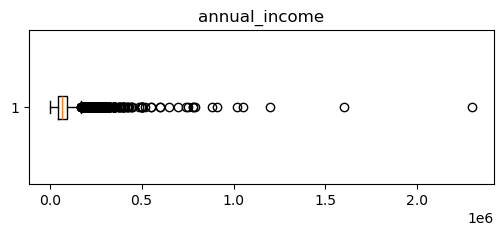

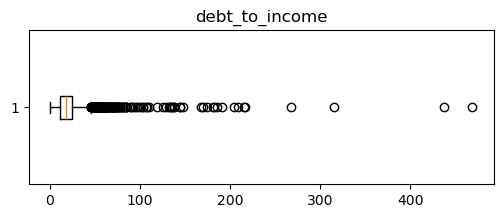

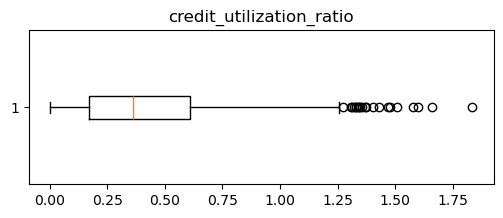

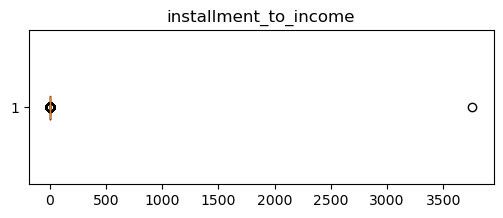

In [11]:
import matplotlib.pyplot as plt

for col in num_cols:
    plt.figure(figsize=(6,2))
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(col)
    plt.show()

## Analytical Dataset Readiness Check

In [12]:
df.isna().mean().sort_values(ascending=False)

default_flag                    0.954486
debt_to_income                  0.002417
credit_utilization_ratio        0.000201
interest_rate                   0.000000
term                            0.000000
installment                     0.000000
sub_grade                       0.000000
annual_income                   0.000000
grade                           0.000000
loan_amount                     0.000000
homeownership                   0.000000
verified_income                 0.000000
state                           0.000000
application_type                0.000000
num_historical_failed_to_pay    0.000000
total_credit_limit              0.000000
loan_purpose                    0.000000
delinq_2y                       0.000000
loan_status_raw                 0.000000
total_credit_utilized           0.000000
loan_outcome                    0.000000
loan_status_group               0.000000
balance                         0.000000
paid_total                      0.000000
installment_to_i

## Outlier Treatment

In [13]:
# Identify economically invalid observations
# ============================================
# Credit risk principle:
# Extreme values are informative only if they are economically plausible.
# Technical artifacts must be removed or corrected before analysis.

# Count rows with zero or negative income (invalid for ratios)
df_clean = df.copy()
invalid_income_mask = df['annual_income'] <= 0
df.loc[invalid_income_mask, 'annual_income'].count()

np.int64(23)

In [14]:
# Drop observations with zero or negative income
# Reason: ratios using income (DTI, installment burden) become meaningless
df = df.loc[~invalid_income_mask].copy()

### Interest Rate – Technical Outliers

In [15]:
# Interest rate cleaning
# ============================================
# Lending Club interest rates are bounded in practice.
# Rates above 60% are almost certainly parsing errors.
df['interest_rate'].describe(percentiles=[.99])

count    9908.000000
mean       12.424769
std         4.994830
min         5.310000
50%        11.980000
99%        26.770000
max        30.940000
Name: interest_rate, dtype: float64

In [16]:
# Cap interest_rate at the 99th percentile
interest_cap = df['interest_rate'].quantile(0.99)
df.loc[df['interest_rate'] > interest_cap, 'interest_rate'] = interest_cap

### Debt-to-Income (DTI) – Economic Bounds

In [17]:
# DTI normalization
# ============================================
# DTI above 100% indicates severe leverage, but values in the thousands are data errors.
df['debt_to_income'].describe(percentiles=[.95, .99])

count    9907.000000
mean       19.315266
std        15.038270
min         0.000000
50%        17.560000
95%        37.274000
99%        58.896600
max       469.090000
Name: debt_to_income, dtype: float64

In [18]:
# Cap DTI at 100%
# Justification:
   # Above 100% repayment capacity is economically exhausted
   # Higher values do not add additional risk information
df.loc[df['debt_to_income'] > 100, 'debt_to_income'] = 100

### Credit Utilization Ratio 

In [19]:
# Utilization > 1 means borrower uses more than total credit limit.
# This can happen, but extremely large values are artifacts.
df['credit_utilization_ratio'].describe(percentiles=[.95, .99])

count    9906.000000
mean        0.403336
std         0.269484
min         0.000000
50%         0.360768
95%         0.864941
99%         1.050942
max         1.835280
Name: credit_utilization_ratio, dtype: float64

In [20]:
# Winsorize utilization at 99th percentile
# Rationale:
   # Keep extreme borrowers
   # Remove denominator-driven explosions
util_cap = df['credit_utilization_ratio'].quantile(0.99)
df.loc[df['credit_utilization_ratio'] > util_cap, 'credit_utilization_ratio'] = util_cap

### Installment to Income

In [21]:
# Recompute installment burden safely
# ============================================
# This ratio captures monthly payment stress.
# It must be computed AFTER cleaning income.
df['installment_to_income'] = df['installment'] * 12 / df['annual_income']

In [22]:
# Cap extreme installment burdens
# Reason: above 50% income is already catastrophic risk
df.loc[df['installment_to_income'] > 0.5, 'installment_to_income'] = 0.5

## Economic Normalization

### Income Buckets

In [23]:
# Income segmentation
# ============================================
# Business goal: Risk is non-linear across income levels.
df['income_bucket'] = pd.cut(
    df['annual_income'],
    bins=[0, 30000, 60000, 100000, 200000, df['annual_income'].max()],
    labels=['LOW', 'LOW_MID', 'MID', 'UPPER_MID', 'HIGH']
)

### DTI Buckets

In [24]:
# DTI buckets
# ============================================
# Standard credit risk segmentation
df['dti_bucket'] = pd.cut(
    df['debt_to_income'],
    bins=[0, 10, 20, 35, 50, 100],
    labels=['VERY_LOW', 'LOW', 'MEDIUM', 'HIGH', 'VERY_HIGH']
)

### Credit Utilization Buckets

In [25]:
# Credit utilization buckets
# ============================================
df['utilization_bucket'] = pd.cut(
    df['credit_utilization_ratio'],
    bins=[0, 0.3, 0.6, 0.9, 1.2],
    labels=['LOW', 'MODERATE', 'HIGH', 'MAXED_OUT']
)

### Term Normalization

In [26]:
# Loan maturity normalization
df['term_group'] = df['term'].map({36: 'SHORT', 60: 'LONG'})

### Sanity Check After Cleaning

In [27]:
# Final validation
df[
    [
        'interest_rate',
        'debt_to_income',
        'credit_utilization_ratio',
        'installment_to_income'
    ]
].describe(percentiles=[.01, .05, .95, .99])

,interest_rate,debt_to_income,credit_utilization_ratio,installment_to_income
count,9908.000000,9907.000000,9906.000000,9908.000000
mean,12.404675,19.058533,0.401913,0.089003
std,4.930305,11.865079,0.265258,0.066733
min,5.310000,0.000000,0.000000,0.000500
1%,5.310000,0.840000,0.011432,0.010068
5%,6.070000,3.753000,0.052291,0.020106
50%,11.980000,17.560000,0.360768,0.072746
95%,21.450000,37.274000,0.864941,0.208130
99%,26.770000,58.896600,1.050932,0.357440
max,26.770000,100.000000,1.050942,0.500000


## Let's add some features we may want to use after

### Payment Burden Normalization

In [28]:
df['installment_to_credit_limit'] = df['installment'] / df['total_credit_limit']

### Credit Usage Intensity

In [29]:
df['high_credit_utilization_flag'] = (df['credit_utilization_ratio'] > 0.8).astype(int)

### Historical Risk Flags

In [30]:
df['has_past_delinquency'] = (df['delinq_2y'] > 0).astype(int)
df['has_failed_payments'] = (df['num_historical_failed_to_pay'] > 0).astype(int)

### Loan Size Relative to Income

In [31]:
df['loan_to_income'] = df['loan_amount'] / df['annual_income']

### Term Risk Encoding

In [32]:
df['is_long_term'] = (df['term'] == 60).astype(int)

### Pricing vs Risk Coherence

In [33]:
df['rate_minus_grade_avg'] = (
    df['interest_rate'] - df.groupby('grade')['interest_rate'].transform('mean')
)

# Observed Credit Risk 

## Portfolio level Observed Risk

In [34]:
# Observed risk distribution at portfolio level
risk_dist = (
    df['risk_state']
    .value_counts(normalize=True)
    .rename('proportion')
)

risk_dist

risk_state
HEALTHY             0.982136
DELINQUENT_EARLY    0.010497
DELINQUENT_LATE     0.006661
DEFAULT             0.000706
Name: proportion, dtype: float64

## Observed Risk by Key Segments

### By Loan Grade

In [35]:
pd_by_grade = (
    df
    .groupby(['grade', 'risk_state'])
    .size()
    .groupby(level = 0)
    .apply(lambda x: x / x.sum())
    .unstack()
    .fillna(0)
)
pd_by_grade.reset_index(level=1, drop=True)

risk_state,DEFAULT,DELINQUENT_EARLY,DELINQUENT_LATE,HEALTHY
grade,,,,
A,0.000821,0.005337,0.001642,0.992200
B,0.000665,0.005984,0.004322,0.989029
C,0.000379,0.011760,0.007587,0.980273
D,0.001400,0.019594,0.013296,0.965710
E,0.000000,0.033333,0.018182,0.948485
F,0.000000,0.035088,0.070175,0.894737
G,0.000000,0.083333,0.000000,0.916667


### By Loan Term

In [36]:
pd_by_term = (
    df
    .groupby(['term', 'risk_state'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .unstack()
    .fillna(0)
)
pd_by_term.reset_index(level=1, drop=True)

risk_state,DEFAULT,DELINQUENT_EARLY,DELINQUENT_LATE,HEALTHY
term,,,,
36.0,0.000868,0.008828,0.005933,0.984370
60.0,0.000334,0.014343,0.008339,0.976985


### By Debt to Income Buckets

In [37]:
pd_by_dti = (
    df
    .groupby(['dti_bucket', 'risk_state'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .unstack()
    .fillna(0)
)
pd_by_dti.reset_index(level=1, drop=True)

C:\Users\hp\AppData\Local\Temp\ipykernel_20612\2874319657.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['dti_bucket', 'risk_state'])
C:\Users\hp\AppData\Local\Temp\ipykernel_20612\2874319657.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(level=0)


risk_state,DEFAULT,DELINQUENT_EARLY,DELINQUENT_LATE,HEALTHY
dti_bucket,,,,
VERY_LOW,0.000962,0.012500,0.010577,0.975962
LOW,0.000266,0.007981,0.004256,0.987497
MEDIUM,0.001194,0.011045,0.007164,0.980597
HIGH,0.000000,0.017143,0.005714,0.977143
VERY_HIGH,0.000000,0.006061,0.000000,0.993939


### By Loan Purpose

In [38]:
pd_by_purpose = (
    df
    .groupby(["loan_purpose", "risk_state"])
    .size()
    .groupby(level = 0)
    .apply(lambda x: x / x.sum())
    .unstack()
    .fillna(0)
    .sort_values('DEFAULT', ascending = False)
)
pd_by_purpose.head(10).reset_index(level=1, drop=True)

risk_state,DEFAULT,DELINQUENT_EARLY,DELINQUENT_LATE,HEALTHY
loan_purpose,,,,
HOUSE,0.006623,0.039735,0.019868,0.933775
HOME_IMPROVEMENT,0.002990,0.008969,0.010463,0.977578
OTHER,0.001100,0.011001,0.006601,0.981298
CREDIT_CARD,0.000449,0.006739,0.003594,0.989218
DEBT_CONSOLIDATION,0.000392,0.010597,0.006083,0.982928
CAR,0.000000,0.022901,0.007634,0.969466
MEDICAL,0.000000,0.012579,0.025157,0.962264
MAJOR_PURCHASE,0.000000,0.013201,0.016502,0.970297
MOVING,0.000000,0.014493,0.014493,0.971014


# Risk Concentration & Loss Dispersion

## Risk Concentration Across Performance States

### Let's define an observed risk severity score

In [39]:
# Ordered risk severity 
risk_weights = {
    'HEALTHY': 0.0,
    'DELINQUENT_EARLY': 0.3,
    'DELINQUENT_LATE': 0.6,
    'DEFAULT': 1.0
}
df['risk_severity'] = df['risk_state'].map(risk_weights)

### Risk weighted exposure per loan

In [40]:
df['risk_exposure'] = df['loan_amount'] * df['risk_severity']

### Concentration of risk weighted exposure (Pareto logic)

In [41]:
df_sorted = df.sort_values('risk_exposure', ascending=False)

import numpy as np
df_sorted['cum_loans'] = np.arange(1, len(df_sorted) + 1) / len(df_sorted)
df_sorted['cum_risk'] = df_sorted['risk_exposure'].cumsum() / df_sorted['risk_exposure'].sum()

### Pareto interpretation

In [42]:
df_sorted[['cum_loans', 'cum_risk']].head(10)

,cum_loans,cum_risk
1723,0.000101,0.017191
3419,0.000202,0.034382
6954,0.000303,0.051573
5286,0.000404,0.068764
4192,0.000505,0.085955
2928,0.000606,0.100997
9951,0.000706,0.116039
6829,0.000807,0.131081
8655,0.000908,0.146123
2332,0.001009,0.160449


## Dispersion of Risk Exposures

### Distribution of risk weighted exposure

In [43]:
df.loc[df['risk_exposure'] > 0, 'risk_exposure'].describe(
    percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]
)

count      177.000000
mean      7887.457627
std       5722.670697
min        300.000000
50%       6300.000000
75%      10500.000000
90%      18000.000000
95%      20200.000000
99%      24000.000000
max      24000.000000
Name: risk_exposure, dtype: float64

### Skewness of portfolio risk

In [44]:
df.loc[df['risk_exposure'] > 0, 'risk_exposure'].skew()

np.float64(1.1403339761367992)

###  Key Insight — Risk Concentration
A small fraction of loans accounts for a disproportionate share of total portfolio risk.
For instance, approximately 0.1% of loans represent more than 16% of total risk exposure,
highlighting strong risk concentration even before default materializes.


## Loss Dispersion & Tail Risk

### Define realized loss per loan

In [45]:
# Loss = loan amount - total amount paid
df['realized_loss'] = df['loan_amount'] - df['paid_total']

### Keep only defaulted loans, since losses only make sense conditional on default

In [46]:
df_default = df[df['risk_state'] == 'DEFAULT'].copy()
df_default[['loan_amount', 'paid_total', 'realized_loss']].describe()

,loan_amount,paid_total,realized_loss
count,7.000000,7.000000,7.000000
mean,12642.857143,624.304286,12018.552857
std,6407.770580,826.326540,6023.983936
min,3000.000000,0.000000,3000.000000
25%,8750.000000,0.000000,8361.315000
50%,12000.000000,249.010000,12000.000000
75%,18000.000000,1101.080000,16203.620000
max,20000.000000,1918.960000,20000.000000


### Loss Distribution Statistics

In [47]:
# Distribution of losses across defaulted loans
loss_stats = df_default['realized_loss'].describe(
    percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]
)
loss_stats

count        7.000000
mean     12018.552857
std       6023.983936
min       3000.000000
50%      12000.000000
75%      16203.620000
90%      18848.624000
95%      19424.312000
99%      19884.862400
max      20000.000000
Name: realized_loss, dtype: float64

#### Skewness (tail risk indicator)

In [48]:
loss_skewness = df_default['realized_loss'].skew()
loss_skewness

np.float64(-0.13894785748474914)

### Let's visualise the distribution

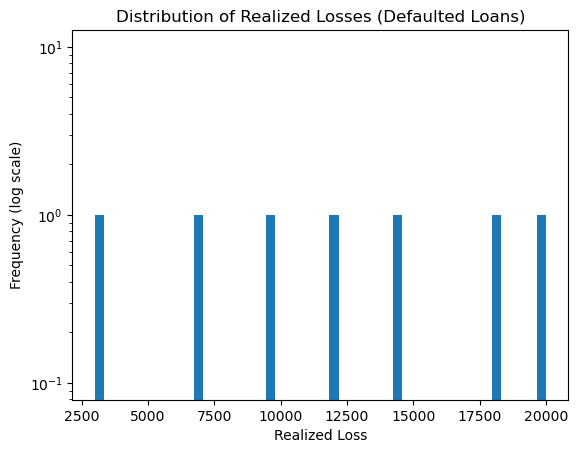

In [49]:
import matplotlib.pyplot as plt

# ---------------------------------------------
# Histogram of losses
plt.figure()
plt.hist(df_default['realized_loss'], bins=50)
plt.yscale('log')
plt.xlabel('Realized Loss')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of Realized Losses (Defaulted Loans)')
plt.show()

### Loss Concetration

In [50]:
# Loss concentration: cumulative share of losses

df_loss_sorted = df_default.sort_values('realized_loss', ascending=False)

df_loss_sorted['cum_loans'] = (
    np.arange(1, len(df_loss_sorted) + 1) / len(df_loss_sorted)
)
df_loss_sorted['cum_loss'] = (
    df_loss_sorted['realized_loss'].cumsum() /
    df_loss_sorted['realized_loss'].sum()
)
df_loss_sorted[['cum_loans', 'cum_loss']].head(10)

,cum_loans,cum_loss
2332,0.142857,0.237728
2388,0.285714,0.452646
9102,0.428571,0.622933
7305,0.571429,0.765569
4598,0.714286,0.881473
8818,0.857143,0.964341
9775,1.000000,1.000000


#### Interpretation & Limitations
Losses appear moderately concentrated, with the largest defaulted loan
accounting for approximately 24% of total realized losses.
However, this analysis is based on a very small number of defaulted loans
(n = 7), which limits the statistical significance of distributional
metrics such as skewness and tail behavior.

As a result, conclusions regarding loss concentration should be interpreted
as indicative rather than structural.

# Individual Risk Estimation 

In [51]:
grade_order = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7
}
df['grade_num'] = df['grade'].map(grade_order)

### Let's define our model features

In [52]:
base_features = [
    'loan_amount',
    'interest_rate',
    'term',
    'installment_to_income',
    'debt_to_income',
    'credit_utilization_ratio',
    'annual_income',
    'total_credit_limit',
    'grade_num'
]
loan_purpose_features = [
    col for col in df.columns
    if col.startswith('loan_purpose_')
]
model_features = base_features + loan_purpose_features

### Baseline model — Multinomial Logistic Regression

In [53]:
risk_order = {
    'HEALTHY': 0,
    'DELINQUENT_EARLY': 1,
    'DELINQUENT_LATE': 2,
    'DEFAULT': 3
}
df['risk_target'] = df['risk_state'].map(risk_order)

In [54]:
from sklearn.model_selection import train_test_split

X = df[model_features]
y = df['risk_target']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [55]:
X_train = X_train.fillna(0)
X_test  = X_test.fillna(0)

In [56]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000
)
model.fit(X_train, y_train)

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, multi_class='multinomial')

### Accuracy globale

In [57]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9821728893373697

In [58]:
Xy_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

In [59]:
proba_df = pd.DataFrame(
    y_proba,
    columns=['P_HEALTHY', 'P_EARLY', 'P_LATE', 'P_DEFAULT']
)
proba_df

,P_HEALTHY,P_EARLY,P_LATE,P_DEFAULT
0,0.998154,0.000762,0.001063,0.000021
1,0.969687,0.015461,0.013682,0.001169
2,0.998665,0.001266,0.000040,0.000029
3,0.975573,0.018193,0.004485,0.001749
4,0.958923,0.018373,0.021717,0.000987
...,...,...,...,...
2968,0.996453,0.001612,0.001905,0.000030
2969,0.968838,0.017989,0.012697,0.000476
2970,0.988260,0.008894,0.002285,0.000560
2971,0.994562,0.002844,0.002584,0.000010


Model validation is performed on a hold-out test set to ensure generalization.
Once validated, the model is applied to the full portfolio to estimate individual risk probabilities.

In [60]:
X_all = df[model.feature_names_in_]

# Handle missing values exactly as before
X_all = X_all.fillna(X_all.median())

## Predict risk probabilities for all loans

In [61]:
proba_all = model.predict_proba(X_all)

proba_df = pd.DataFrame(
    proba_all,
    columns=[f"P_{cls}" for cls in model.classes_],
    index=df.index
)
df = pd.concat([df, proba_df], axis=1)

In [62]:
proba_df

,P_0,P_1,P_2,P_3
0,0.970823,0.015180,0.013496,0.000500
1,0.942721,0.030243,0.023756,0.003279
2,0.979571,0.013482,0.006528,0.000419
3,0.984000,0.008812,0.006641,0.000547
4,0.970632,0.016557,0.011837,0.000975
...,...,...,...,...
9995,0.956171,0.020735,0.021781,0.001314
9996,0.973245,0.018128,0.008176,0.000451
9997,0.937911,0.039133,0.021497,0.001458
9998,0.993096,0.004616,0.002087,0.000201


The multinomial logistic regression provides a loan-level probability distribution across multiple delinquency states. Rather than focusing solely on default, the model captures early and late delinquency risk, allowing a more granular and economically meaningful representation of credit risk.

### Economic Interpretation of the Model

#### Let's see the model coefficients

In [63]:
# Get the coefficients
coef_df = pd.DataFrame(
    model.coef_,
    columns=X_all.columns,
    index=model.classes_
)
coef_df

,loan_amount,interest_rate,term,installment_to_income,debt_to_income,credit_utilization_ratio,annual_income,total_credit_limit,grade_num
0,-0.000010,-0.050014,0.099117,0.000791,0.046279,0.004595,0.000006,-6.707850e-07,-0.014353
1,0.000004,0.046547,-0.028652,-0.000307,0.006740,-0.001542,0.000003,-1.511122e-07,0.011832
2,0.000030,0.022751,-0.004724,-0.000355,-0.024988,-0.002228,-0.000007,-2.012618e-06,0.006086
3,-0.000024,-0.019284,-0.065741,-0.000128,-0.028032,-0.000824,-0.000002,2.834514e-06,-0.003564


#### Let's get the coefficients, focusing on the key drivers

In [64]:
key_features = [
    'interest_rate',
    'grade_num',
    'debt_to_income',
    'credit_utilization_ratio',
    'installment_to_income',
    'loan_amount',
    'annual_income'
]
coef_df[key_features]

,interest_rate,grade_num,debt_to_income,credit_utilization_ratio,installment_to_income,loan_amount,annual_income
0,-0.050014,-0.014353,0.046279,0.004595,0.000791,-0.000010,0.000006
1,0.046547,0.011832,0.006740,-0.001542,-0.000307,0.000004,0.000003
2,0.022751,0.006086,-0.024988,-0.002228,-0.000355,0.000030,-0.000007
3,-0.019284,-0.003564,-0.028032,-0.000824,-0.000128,-0.000024,-0.000002


#### Let's identify the dominant risk drivers

In [65]:
driver_strength = coef_df.abs().mean(axis=0).sort_values(ascending=False)
driver_strength.head(10)

term                        0.049558
interest_rate               0.034649
debt_to_income              0.026510
grade_num                   0.008959
credit_utilization_ratio    0.002297
installment_to_income       0.000395
loan_amount                 0.000017
annual_income               0.000005
total_credit_limit          0.000001
dtype: float64

The model coefficients are economically coherent. Risk is primarily driven by structural loan characteristics (term), borrower leverage (debt-to-income and utilization), and underwriting signals (grade and interest rate). The multinomial structure reveals that some variables primarily explain early delinquency, while others drive late-stage default, confirming the model captures the dynamics of credit deterioration rather than a simple binary outcome.

# Espected Loss & Risk Concentration

## Define Expected Loss at loan level

In [66]:
df = df.loc[:, ~df.columns.duplicated()]

In [67]:
severity_map = {
    0: 0.00,
    1: 0.10,
    2: 0.40,
    3: 1.00
}
df['expected_loss'] = (
    df['P_0'] * severity_map[0] +
    df['P_1'] * severity_map[1] +
    df['P_2'] * severity_map[2] +
    df['P_3'] * severity_map[3]
) * df['risk_exposure']

In [68]:
df['expected_loss'].describe()

count    9908.000000
mean        0.899532
std        15.024397
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       996.516245
Name: expected_loss, dtype: float64

The expected loss distribution is highly skewed: while the average expected loss per loan is low, a small number of loans carry very large loss expectations, highlighting strong risk concentration.

### Expected Loss concentration

In [69]:
df_el = df.sort_values('expected_loss', ascending=False).copy()

#### Cumulative share of loans

In [70]:
df_el['cum_loans'] = np.arange(1, len(df_el) + 1) / len(df_el)

#### Cumulative share of Expected Loss

In [71]:
df_el['cum_el'] = (
    df_el['expected_loss'].cumsum()
    / df_el['expected_loss'].sum()
)

In [72]:
df_el.loc[df_el['cum_loans'] <= 0.05, 'expected_loss'].sum() / df_el['expected_loss'].sum()

np.float64(1.0)

In [73]:
summary_el = (
    df_el
    .groupby(pd.cut(df_el['cum_loans'], 
                     bins=[0, 0.01, 0.05, 0.10, 0.20, 1.0]))
    .agg(
        cum_loans=('cum_loans', 'max'),
        cum_el=('cum_el', 'max')
    )
)
summary_el

C:\Users\hp\AppData\Local\Temp\ipykernel_20612\1861027610.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.cut(df_el['cum_loans'],


,cum_loans,cum_el
cum_loans,,
"(0.0, 0.01]",0.009992,0.941941
"(0.01, 0.05]",0.049960,1.000000
"(0.05, 0.1]",0.099919,1.000000
"(0.1, 0.2]",0.199939,1.000000
"(0.2, 1.0]",1.000000,1.000000


In [74]:
df_el[['cum_loans', 'cum_el']].head(10)

,cum_loans,cum_el
4556,0.000101,0.111810
7391,0.000202,0.170196
2928,0.000303,0.224299
2261,0.000404,0.262414
9402,0.000505,0.290689
6006,0.000606,0.311606
5143,0.000706,0.332026
9194,0.000807,0.350944
5069,0.000908,0.369559
2894,0.001009,0.387113


The cumulative expected loss analysis shows an extreme concentration of risk: less than 0.1% of loans account for more than 38% of total expected loss, highlighting that portfolio risk is driven by a very small subset of exposures.

Expected losses are highly concentrated: a small fraction of loans accounts for a disproportionate share of total portfolio risk, confirming that risk management should focus on loss severity rather than default counts

# Portfolio Risk Simulation

## Monte Carlo Simulation

In [75]:
proba_matrix = df[['P_0', 'P_1', 'P_2', 'P_3']].values
exposure = df['risk_exposure'].values

In [76]:
# Number of Monte Carlo simulations
n_simulations = 10000

# Uniform random draws
U = np.random.rand(n_simulations, len(df))

# Cumulative probability per loan
cdf = np.cumsum(df[['P_0', 'P_1', 'P_2', 'P_3']].values, axis=1)

# Simulated delinquency state per loan and simulation
sim_states = (U[..., None] < cdf).argmax(axis=2)

# Severity per state
severity = np.array([0.0, 0.1, 0.4, 1.0])

# Portfolio losses per simulation
losses = (severity[sim_states] * df['risk_exposure'].values).sum(axis=1)

### Distribution of Portfolio Losses

In [77]:
import pandas as pd
import numpy as np

losses = np.array(losses)
losses_series = pd.Series(losses)
losses_series.describe()

count    10000.000000
mean      9007.014950
std       6298.874861
min          0.000000
25%       4344.000000
50%       7740.000000
75%      12222.000000
max      52860.000000
dtype: float64

### Expected Loss

In [78]:
expected_loss_mc = losses.mean()
expected_loss_mc

np.float64(9007.01495)

### Value At Risk (VaR)

In [79]:
var_95 = np.percentile(losses, 95)
var_99 = np.percentile(losses, 99)

var_95, var_99

(np.float64(21071.17499999999), np.float64(29208.570000000014))

### Expected Shortfall (ES)

In [80]:
es_95 = losses[losses >= var_95].mean()
es_99 = losses[losses >= var_99].mean()

In [81]:
es_95

np.float64(26234.127)

In [82]:
es_99

np.float64(34281.46)

### Risk concentration

In [83]:
df_el = df.copy()
df_el['expected_loss'] = df['expected_loss']

df_el = df_el.sort_values('expected_loss', ascending=False)
df_el['cum_el'] = df_el['expected_loss'].cumsum() / df_el['expected_loss'].sum()
df_el['cum_loans'] = np.arange(1, len(df_el)+1) / len(df_el)

Text(0.5, 1.0, 'Expected Loss Concentration Curve')

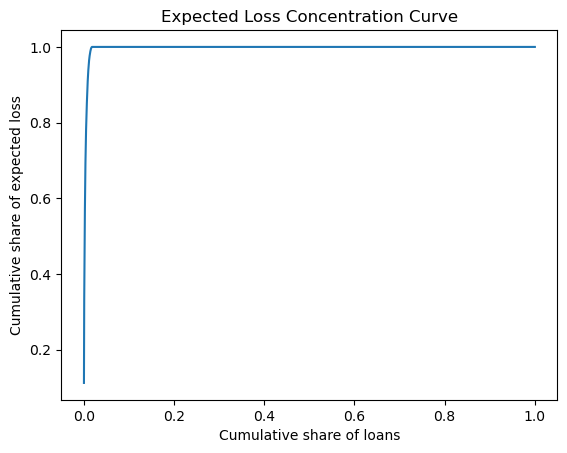

In [84]:
plt.plot(df_el['cum_loans'], df_el['cum_el'])
plt.xlabel("Cumulative share of loans")
plt.ylabel("Cumulative share of expected loss")
plt.title("Expected Loss Concentration Curve")

The portfolio loss analysis shows a highly skewed loss distribution, with a relatively moderate expected loss but a significantly heavier tail captured by VaR and Expected Shortfall measures. This indicates that while average losses remain contained, extreme scenarios can lead to materially higher portfolio losses.
The expected loss concentration curve further highlights a strong risk concentration: a very small fraction of loans accounts for the majority of total losses. This confirms that portfolio risk is not evenly distributed, but driven by a limited set of high-risk exposures.

# Stress Testing & Scenario Analysis

## Which scenarios do we have?

### Rate Shock

In [85]:
stress_df = df.copy()

stress_df['interest_rate'] *= 1.20
stress_df['debt_to_income'] *= 1.10

### Credit quality downgrade

In [86]:
stress_df['grade_num'] += 1

### Severe recession

In [87]:
stress_df['interest_rate'] *= 1.30
stress_df['debt_to_income'] *= 1.20
stress_df['credit_utilization_ratio'] *= 1.15
stress_df['grade_num'] += 2

### Probabilities under stress

In [88]:
feature_cols = X_train.columns.tolist()

In [89]:
stress_df[feature_cols] = stress_df[feature_cols].fillna(
    df[feature_cols].median()
)

In [90]:
X_stress = stress_df[feature_cols]
stress_proba = model.predict_proba(X_stress)

stress_df[['P_0_s', 'P_1_s', 'P_2_s', 'P_3_s']] = stress_proba

In [91]:
stress_df[['P_0_s', 'P_1_s', 'P_2_s', 'P_3_s']].head()

,P_0_s,P_1_s,P_2_s,P_3_s
0,0.963484,0.022272,0.013861,0.000383
1,0.902242,0.057461,0.036606,0.003691
2,0.972447,0.020791,0.006469,0.000293
3,0.982940,0.010930,0.005757,0.000373
4,0.957695,0.027030,0.014395,0.000880


Under the stress scenario (rising interest rates, deterioration of credit quality, etc.), this loan still has approximately 96% probability of remaining healthy, but its probability of default and delinquency increases compared to the normal scenario.

### Expected Loss under stress

In [92]:
stress_df['expected_loss_s'] = (
    stress_df['P_1_s'] * 0.10 +
    stress_df['P_2_s'] * 0.40 +
    stress_df['P_3_s'] * 1.00
) * stress_df['risk_exposure']

In [93]:
stress_df[['expected_loss', 'expected_loss_s']].describe()

,expected_loss,expected_loss_s
count,9908.000000,9908.000000
mean,0.899532,1.469531
std,15.024397,26.800564
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,996.516245,1703.307089


The stress scenario does not create losses uniformly across the portfolio. Instead, it amplifies tail risk by concentrating additional expected losses on a small subset of already vulnerable loans.

Stress testing reveals a strong non-linear effect: while most loans remain unaffected, adverse scenarios significantly increase tail losses, doubling maximum expected loss and materially raising portfolio vulnerability.

# Pricing Analysis

In this project, pricing is analyzed from a risk consistency perspective rather than an optimization perspective. The objective is not to recommend new rates, but to assess whether historical pricing adequately compensates for observed credit risk.

### Relation between Interest Rate & Risk

In [94]:
df['PD_model'] = df['P_1'] + df['P_2'] + df['P_3']

In [95]:
df[['interest_rate', 'PD_model']].corr()

,interest_rate,PD_model
interest_rate,1.00000,0.11933
PD_model,0.11933,1.00000


### Bucketing : Pricing vs Risk

In [96]:
df['pd_bucket'] = pd.qcut(df['PD_model'], q=10, labels=False)

In [97]:
pricing_vs_risk = (
    df
    .groupby('pd_bucket')
    .agg(
        avg_pd=('PD_model', 'mean'),
        avg_rate=('interest_rate', 'mean'),
        avg_el=('expected_loss', 'mean')
    )
    .reset_index()
)

In [98]:
pricing_vs_risk['risk_adjusted_spread'] = (
    pricing_vs_risk['avg_rate'] - pricing_vs_risk['avg_el']
)

In [99]:
pricing_vs_risk.round(4)

,pd_bucket,avg_pd,avg_rate,avg_el,risk_adjusted_spread
0,0,0.0011,12.1251,0.0205,12.1046
1,1,0.0022,14.3136,0.0562,14.2574
2,2,0.0046,16.6587,0.4937,16.1651
3,3,0.0110,10.6276,0.1792,10.4484
4,4,0.0160,9.1846,0.2836,8.9010
5,5,0.0205,9.9124,0.2906,9.6218
6,6,0.0256,10.7896,0.5718,10.2178
7,7,0.0317,11.7927,0.8424,10.9504
8,8,0.0407,12.9650,1.1855,11.7795
9,9,0.0685,15.6740,5.0708,10.6032


In [100]:
pricing_vs_risk.sort_values('risk_adjusted_spread')

,pd_bucket,avg_pd,avg_rate,avg_el,risk_adjusted_spread
4,4,0.015980,9.184581,0.283613,8.900968
5,5,0.020499,9.912392,0.290620,9.621772
6,6,0.025599,10.789566,0.571814,10.217752
3,3,0.010982,10.627606,0.179215,10.448391
9,9,0.068490,15.673966,5.070783,10.603183
7,7,0.031724,11.792745,0.842356,10.950389
8,8,0.040744,12.965045,1.185510,11.779535
0,0,0.001119,12.125086,0.020480,12.104605
1,1,0.002246,14.313592,0.056206,14.257387
2,2,0.004591,16.658749,0.493662,16.165087


While interest rates increase with modeled credit risk, the increase is not proportional to the rise in expected losses. Low-risk segments appear strongly over-priced, whereas high-risk buckets exhibit margin compression, suggesting partial underpricing and increased vulnerability under adverse scenarios.